# Simple Deep Q Network (DQN)

Q: The expected future rewards discounted over time.

Q is learned through the Bellman equation, where the Q of any state and action is the immediate reward achieved + the discounted maximum Q value (the best action taken) of next best action, where gamma is the discount rate.

$$Q(s,a)=r + \gamma.maxQ(s',a')$$

## General method:

Overall aim is to create a neural network that predicts Q. Improvement comes from improved accuracy in predicting 'current' understood Q, and in revealing more about Q as knowledge is gained (some rewards are only discovered after time). 

    1) Initiate parameters for Q(s,a) with random weight.
    2) Perform a number of random actions before training starts (we'll use 1,000 here)
    3) With reducing probability select a random action, or best current  action, argmax Q(s,a). 
    4) Execute action a, and observe reward r and next state s.
    5) Store transition (s,a,r,s) in the memory
    6) Sample random minibatch of transitions from the memory. Random sampling from the replay buffer avoids autocorrelation problems that can occur if using current state net 
    7) For every transition in the buffer, calculate y=r if the episode has ended at this step, or y = r + gamma(max Q) 
    8) Update Q(s,a) in network by minimising the loss in respect to model parameters
    9) Repeat from (2)

In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim

from collections import deque

In [2]:
# Set up environment
ENV_NAME = "CartPole-v0"
DISPLAY_ON_SCREEN = False
# Discount rate of future rewards
GAMMA = 0.99
# Learing rate for neural network
LEARNING_RATE = 0.001
# Maximum number of game steps (state, action, reward, next state) to keep
MEMORY_SIZE = 5000
# Frequency of neural net 
BATCH_SIZE = 5
# Number of game steps to play before starting training
REPLAY_START_SIZE = 1000
# Exploration rate (episolon) is probability of choosign a random action
EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.001
# Reduction in epsilon with each game step
EXPLORATION_DECAY = 0.95
# Target rewards
TARGET_REWARD = 200
# Number of times target must be met without break
TARGET_PERIOD = 5

## Define DQN class

In [3]:
class DQN(nn.Module):

    """
    Deep Q Network solver. Includes control variables, memory of 
    state/action/reward/end, neural net,and methods to act, 
    remember, and update neural net by sampling from memory.
    """
    
    def __init__(self, observation_space, action_space):
        """Constructor method. Set up memory and neural nets."""
        
        # Set starting exploration rate
        self.exploration_rate = EXPLORATION_MAX
        
        # Set up action space (choice of possible actions)
        self.action_space = action_space
        
        # Set up memory for state/action/reward/next_state/done
        # Deque will drop old data when full
        self.memory = deque(maxlen=MEMORY_SIZE)

        # Set up neural net
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(observation_space, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, action_space))
        
        # Set loss function and optimizer
        self.objective = nn.MSELoss()
        self.optimizer = optim.Adam(
            params=self.net.parameters(), lr=LEARNING_RATE)

        
    def act(self, state):
        """Act either randomly or by redicting action that gives max Q"""
        
        # Act randomly if random number < exploration rate
        if np.random.rand() < self.exploration_rate:
            action = random.randrange(self.action_space)
            
        else:
            # Otherwise get predicted Q values of actions
            q_values = self.net(torch.FloatTensor(state))
            # Get index of action with best Q
            action = np.argmax(q_values.detach().numpy()[0])
        
        return  action
    
    
    def experience_replay(self):
        """Update model by sampling (s/a/r/s') from memory. As the memory 
        accumulates knowledge of rewards, this will lead to a better ability to
        estimate Q (which depends on future possible rewards."""
        
        # Do not try to train model if memory is less than reqired batch size
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Reduce exploration rate down to minimum
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
        
        # Sample a random batch from memory
        batch = random.sample(self.memory, BATCH_SIZE)
                
        for state, action, reward, state_next, terminal in batch:
            # If terminal then Q = reward (-1), otherwsie use Belman equation
            if terminal:
                q_update = reward
            else:
                # Get best possible Q for next action
                action_q = self.net(torch.FloatTensor(state_next))
                action_q = action_q.detach().numpy().flatten()
                best_next_q = np.amax(action_q)
                # Calculate current Q using Bellman equation
                q_update = (reward + GAMMA * best_next_q)
                
            # Get predicted Q values for current state
            q_values = self.net(torch.FloatTensor(state))
            
            # Update predicted Q for current state/action
            q_values[0][action] = q_update
            
            # Update neural net to better predict the updated Q value
            
            # Reset net gradients
            self.optimizer.zero_grad()  
            # calculate loss
            loss_v = nn.MSELoss()(self.net(torch.FloatTensor(state)), q_values)
            # Backpropogate loss
            loss_v.backward()
            # Update network gradients
            self.optimizer.step()  
            
    
    def forward(self, x):
        """Feed forward function for neural net"""
        
        return self.net(x)
    
    
    def remember(self, state, action, reward, next_state, done):
        """state/action/reward/next_state/done"""
        
        self.memory.append((state, action, reward, next_state, done))

## Plot results

In [4]:
def plot_results(run, exploration, score):
    """Plot results at end of run"""
    
    # Set up chart (ax1 and ax2 share x-axis)
    fig = plt.figure(figsize=(6,6,))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    # Plot results
    ax1.plot(run, exploration, label='exploration', color='g')
    ax2.plot(run, score, label='score', color='r')
    
    # Set axes
    ax1.set_xlabel('run')
    ax1.set_ylabel('exploration', color='g')
    ax2.set_ylabel('score', color='r')
    
    # Show
    plt.show()

## Main code

In [5]:
def cartpole():
    """Main program loop"""
    # Set up game environemnt
    env = gym.make(ENV_NAME)
    
    # Get number of observations returned for state
    observation_space = env.observation_space.shape[0]
    
    # Get number of actions possible
    action_space = env.action_space.n
    
    # Set up neural net
    dqn = DQN(observation_space, action_space)
    
    # Set up list for results
    results_run = []
    results_exploration = []
    results_score = []
    
    # Set up run counter and learning loop
    run = 0
    continue_learning = True
    
    # Continue repeating games (episodes) until target complete
    while continue_learning:
        
        # Increment run (episode) counter
        run += 1
        
        # Start run and get first state observations
        state = env.reset()
        
        # Reshape state into 2D array with state obsverations as first 'row'
        state = np.reshape(state, [1, observation_space])
        
        # Reset game step counter
        step = 0
        
        # Continue loop until episode complete
        while True:
            
            # Increment step counter
            step += 1
            
            # Get action to take
            action = dqn.act(state)
            
            # Act
            state_next, reward, terminal, info = env.step(action)
            
            # Display on screen in required
            if DISPLAY_ON_SCREEN:
                env.render()
                      
            # Convert step reward to negative if end of run
            reward = reward if not terminal else -reward
            
            # Get observations for new state (s')
            state_next = np.reshape(state_next, [1, observation_space])
            
            # Record state, action, reward, new state & terminal
            dqn.remember(state, action, reward, state_next, terminal)
            
            # Update state
            state = state_next
            
            # Update neural net
            if len(dqn.memory) >= REPLAY_START_SIZE:
                dqn.experience_replay()
            
            # Actions to take if end of game episode
            if terminal:
                # Clear print row content
                clear_row = '\r' + ' '*79 + '\r'
                print (clear_row, end ='')
                print (f'Run: {run}, ', end='')
                print (f'exploration: {dqn.exploration_rate: .3f}, ', end='')
                print (f'score: {step}', end='')
                
                # Add to results lists
                results_run.append(run)
                results_exploration.append(dqn.exploration_rate)
                results_score.append(step)
                
                # Get average of last 5 games
                if len(results_score) >= TARGET_PERIOD:
                    average_reward = np.mean(results_score[-TARGET_PERIOD:])
                    # Stop if target met in all required episodes
                    if average_reward >= TARGET_REWARD:
                        # Stop learning loop
                        continue_learning = False
                # End episode loop
                break
                


    # Target reached. Plot results
    plot_results(results_run, results_exploration, results_score)

Run: 151, exploration:  0.001, score: 200                                      

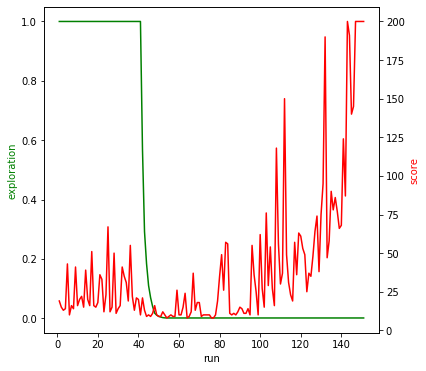

In [6]:
cartpole()